<a href="https://colab.research.google.com/github/Augista/PredictCryptoMarketIndo/blob/main/PredictCryptoMarketIndo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean Squared Error: 179730.10125000018


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Cross-validated R² scores: [-64.60722417   0.           0.           0.                  nan]
[675.3540686880486, 752.754015470512, 726.9667694981125, 720.0821382185269, 720.1160452907874, 748.4445444358363]


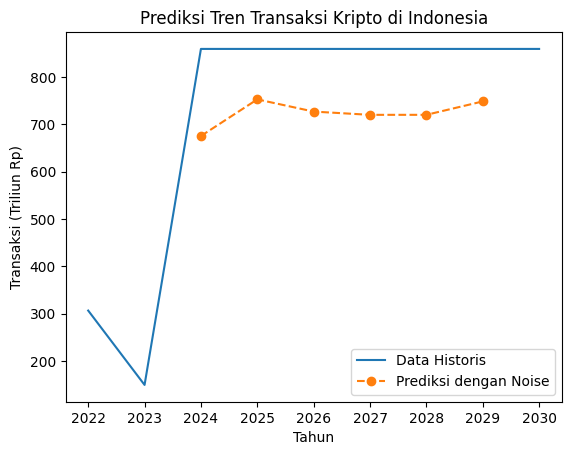

   Tahun  Prediksi Transaksi (Triliun Rp)
0   2024                       675.354069
1   2025                       752.754015
2   2026                       726.966769
3   2027                       720.082138
4   2028                       720.116045
5   2029                       748.444544


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Mengumpulkan Data dari berita ("https://www.kemendag.go.id/berita/pojok-media/bappebti-targetkan-transaksi-kripto-rp800-triliun-pada-2024#:~:text=1%2F2024).-,Berdasarkan%20data%20Bappebti%20tercatat%20adanya%2018%2C51%20juta%20investor%20aset,angka%20Rp%20149%2C25%20triliun.")
data = {
    "Tahun": [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    "Transaksi": [306.4, 149.25, 859.4, None, None, None, None, None, None],
    "Jumlah_Investor": [15.5, 18.51, None, None, None, None, None, None, None],
    "Dominasi_Bitcoin": [0.5, 0.502, None, None, None, None, None, None, None]
}

# Mbuat DataFrame
df = pd.DataFrame(data)

# Mengisi Nilai yang Hilang
df['Transaksi'] = df['Transaksi'].interpolate()
df['Jumlah_Investor'] = df['Jumlah_Investor'].interpolate()
df['Dominasi_Bitcoin'] = df['Dominasi_Bitcoin'].interpolate()

# Data untuk jadi Model Prediksi
X = df[['Tahun', 'Jumlah_Investor', 'Dominasi_Bitcoin']]
y = df['Transaksi']

#Membagi Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#melatih dengan hypertuning model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mengisi missing value
for column in ['Jumlah_Investor', 'Dominasi_Bitcoin']:
    df[column].fillna(method='ffill', inplace=True)
    predictions = grid_search.predict(df[['Tahun', 'Jumlah_Investor', 'Dominasi_Bitcoin']])
    df[column].fillna(pd.Series(predictions), inplace=True)

#Eval model buat diprediksi
X = df[['Tahun', 'Jumlah_Investor', 'Dominasi_Bitcoin']]
y = df['Transaksi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Cross-validation untuk R² score
scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f'Cross-validated R² scores: {scores}')

future_years = pd.DataFrame({
    'Tahun': range(2024, 2030),
    'Jumlah_Investor': [20, 23, 27, 31, 36, 42],
    'Dominasi_Bitcoin': [0.5, 0.48, 0.47, 0.45, 0.44, 0.43]
})


predictions = []
for year in future_years['Tahun']:
    pred = best_model.predict(future_years[future_years['Tahun'] == year])[0]
    noise = np.random.normal(0, 20)  # Menambah noise data
    predictions.append(pred + noise)

print(predictions)

#Visual dari data hasil
plt.plot(df['Tahun'], df['Transaksi'], label='Data Historis')
plt.plot(future_years['Tahun'], predictions, label='Prediksi dengan Noise', linestyle='--', marker='o')
plt.legend()
plt.xlabel('Tahun')
plt.ylabel('Transaksi (Triliun Rp)')
plt.title('Prediksi Tren Transaksi Kripto di Indonesia')
plt.show()

# Nampilin prediksi noise
predictions_df = pd.DataFrame({
    'Tahun': future_years['Tahun'],
    'Prediksi Transaksi (Triliun Rp)': predictions
})

print(predictions_df)
